# SUBMISSION : Exam Project VII (Part 02)
            (Submission by SHUBHAM KUMAR - Mat.# 5547548)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as spo
import plotly.graph_objects as go
from scipy.signal import butter, filtfilt, decimate, welch

# Load data
data = spo.loadmat("Proj_7-2.mat")

vertices = data["vertices"].squeeze()                      # shape: (225420, 2)
entropy_snapshots = data["entropy_snapshots"].squeeze()    # shape: (225420, 72)

x, y = vertices[:,0], vertices[:,1]              # represent the x,y-coordinate of each node

print(f"'vertices' array represent the Spatial grid (x,y) coordinate for each {vertices.shape[0]} rows denoting mesh nodes.")
print(f"'entropy_snapshots' represent the Entropy field values at every {entropy_snapshots.shape[0]} mesh nodes, over time of {entropy_snapshots.shape[1]} time snapshots.")

'vertices' array represent the Spatial grid (x,y) coordinate for each 225420 rows denoting mesh nodes.
'entropy_snapshots' represent the Entropy field values at every 225420 mesh nodes, over time of 72 time snapshots.


### Task 2.1

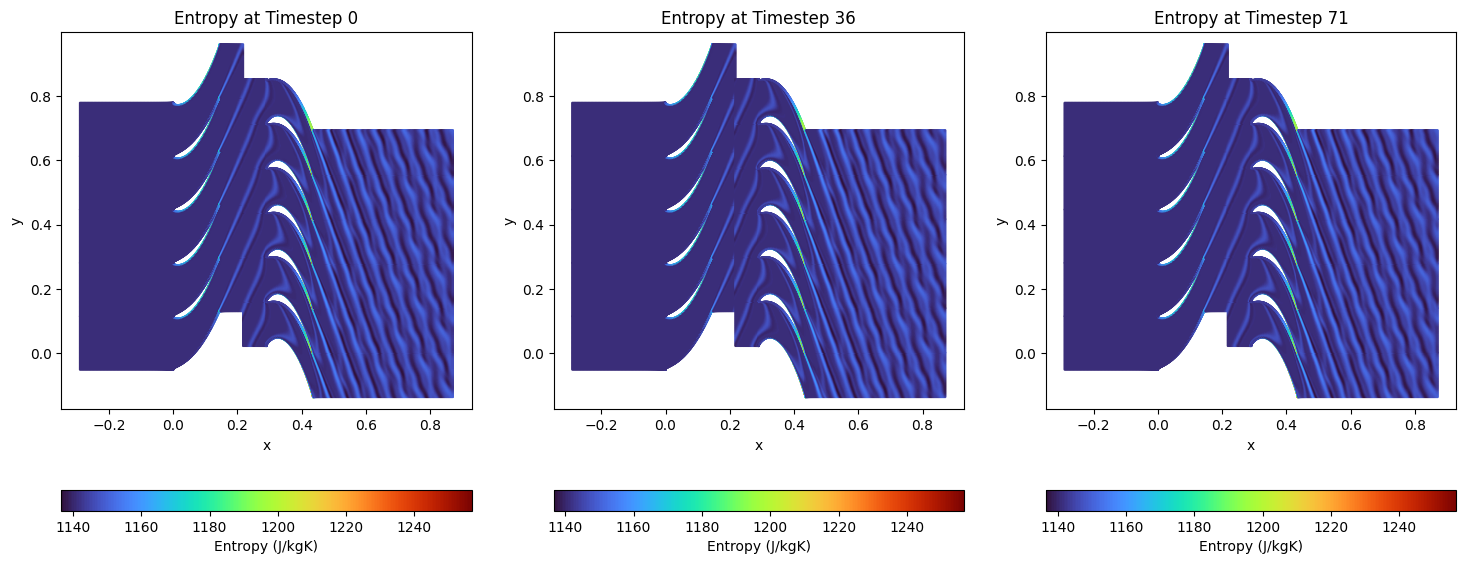

In [2]:
"""
------------------------ TASK 2.1 -----------------------------------------------
Visualisation of how the entropy field evolves over-time by plotting it at three representative time steps (t = 0, 36, 71). 
This identifies the spatial structure of flow features like wakes, blade interactions, and high-entropy regions in 2D turbine.
"""

timesteps = [0, 36, 71]       # Choosing random 3 time steps (start, middle, end)

fig, axes = plt.subplots(1, 3, figsize=(18, 7))
for i, t in enumerate(timesteps):
    """
    Parameters : 
        - t : selected timestpe sindex from the list of randomly selected "timesteps"
        - cmap='turbo' : vivid colour map for better contrast in flow features.
        - s=0.3 : very small marker size, to accommodate dense meshes
    Results : 
        - entropy_t contains the entropy values at all the mesh points at time t timestep
    """
    entropy_t = entropy_snapshots[:, t]
    scatter = axes[i].scatter(x, y, c=entropy_t, cmap='turbo', s=0.3)
    axes[i].set_title(f"Entropy at Timestep {t}")
    axes[i].set_xlabel("x")
    axes[i].set_ylabel("y")
    axes[i].axis("equal")
    plt.colorbar(scatter, ax=axes[i], label='Entropy (J/kgK)', orientation='horizontal')
plt.show()

### Task 2.2

In [3]:
"""
------------------------ TASK 2.2 -----------------------------------------------
Extracting the most energetic flow structures from the entropy snapshots using the Snapshot POD method.

(a) Built the Data-matrix X of size (n x m), where n-> spatial points, and m-> timesteps.
(b) Subtracted the mean field to retain only the fluctuating part of the flow (turbulence).
    Computed covariance matrix using snapshot POD approach (captures how fluctuations at different times correlate)
(c) Solved for eigenvalues and eigenvectors, representing the energy of each mode, and spatial POD modes, respectively.
"""

# (a)
X = entropy_snapshots.copy()                    # Data matrix -> Shape: (225420, 72) -> shape (n x m)
n, m = X.shape[0], X.shape[1]


# (b)
mean_field = np.mean(X, axis=1, keepdims=True)  # (time-averaged mean) -> shape: (225420, 1)
X_fluct = X - mean_field                        # shape (225420, 72) -> mean-subtracted entropy field
R = (X_fluct.T @ X_fluct) / X_fluct.shape[1]    # Covariance = Correlation matrix Shape : (72 x 72)
                                                # captures how fluctuations at different times correlate

# (c)
eigvals, eigvecs = np.linalg.eigh(R)            # eigvals.shape = (72,)      and     eigvecs.shape = (72,72)

idx = np.argsort(eigvals)[::-1]                 # Sorting eigenvalues and eigenvectors in descending order
eigvals = eigvals[idx]                          # Shape : (72,) -> represents ==> Energy content in each mode, in descending order
eigvecs = eigvecs[:, idx]                       # Shape : (72,72) -> Identifies dominant patterns in time (descending order)

# Computing POD modes
POD_modes = X_fluct @ eigvecs                                     # Shape: (225420, 72)
POD_modes = POD_modes[:, :10] / np.sqrt(eigvals[:10] * (m-1))     # Normalize first 10 modes


# -------------------------------------------------------------------------------------
# Extra (not asked in the task): Checking mode orthogonality

def check_mode_orthogonality(modes):
    dot_matrix = (modes.T @ modes).sum(axis=0)
    return dot_matrix

print(f"Property of POD mode orthogonality validated. As below for each of the {POD_modes.shape[1]} modes orthogonality confirms :")
print(check_mode_orthogonality(POD_modes))

Property of POD mode orthogonality validated. As below for each of the 10 modes orthogonality confirms :
[1.01408451 1.01408451 1.01408451 1.01408451 1.01408451 1.01408451
 1.01408451 1.01408451 1.01408451 1.01408451]


### Task 2.3

UᵀU for mode 1 is = 1.01408
UᵀU for mode 2 is = 1.01408
UᵀU for mode 3 is = 1.01408
UᵀU for mode 4 is = 1.01408


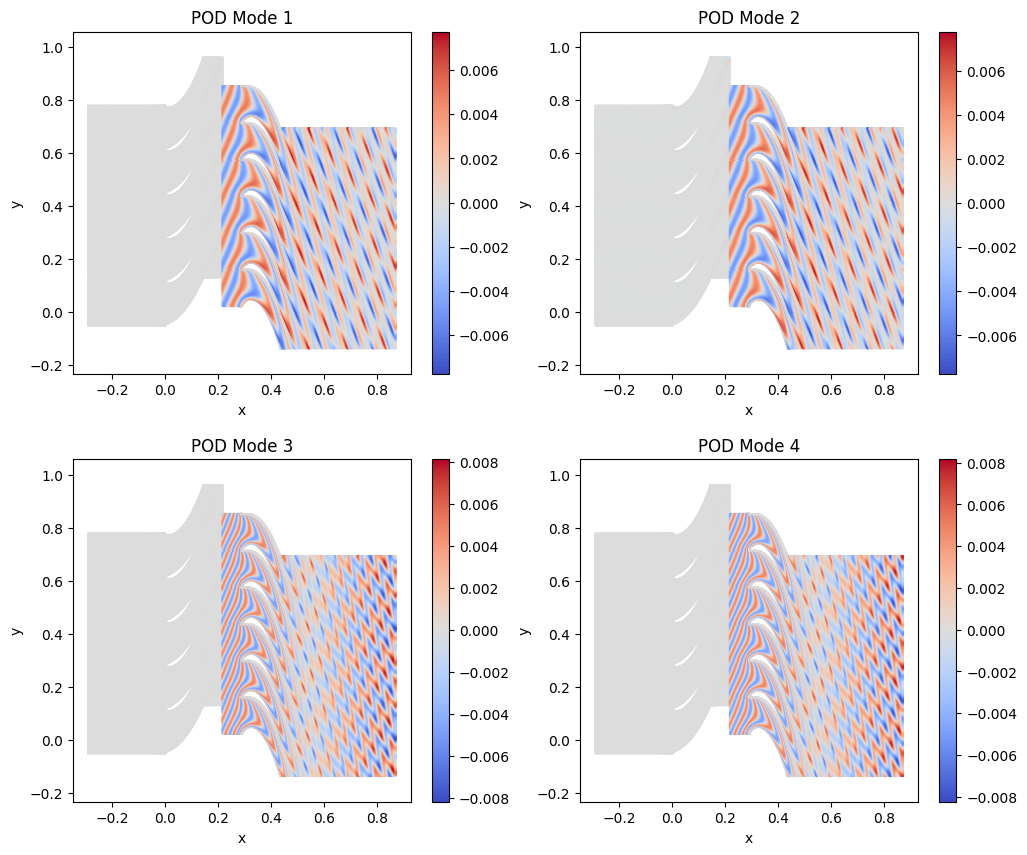

In [4]:
"""
------------------------ TASK 2.3 -----------------------------------------------
Interpret the dominant spatial structures in the flow field by visualising the first four spatial POD modes.
These modes represent the most energetic and coherent flow features.
"""

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.subplots_adjust(hspace=0.25)
for i in range(4):
    """
    Parameters : 
        - cmap='coolwarm' : diverging colour map for better contrast in flow features.
        - s=0.3 : very small marker size, to accommodate dense meshes
    Results : 
        - Computing dominant spatial POD modes, representing the most energetic flow features.
        - Also UᵀU for each mode confirms the property of orthogonality.
    """
    ax = axes.flat[i]
    sc = ax.scatter(x, y, c=POD_modes[:, i], cmap='coolwarm', s=0.3)
    ax.set_title(f"POD Mode {i + 1}")
    ax.axis("equal")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    plt.colorbar(sc, ax=ax)
    print(f'UᵀU for mode {i+1} is = {check_mode_orthogonality(POD_modes[:,i]):.5f}')
plt.show()


### Task 2.4

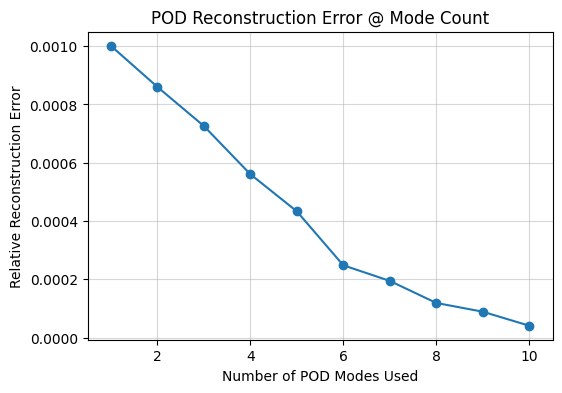

In [5]:
"""
------------------------ TASK 2.4 -----------------------------------------------
Reconstructed the flow using rank-r approximation of the flow, based on the POD modes.
Showcasing the efficiency of dimensionality reduction and determining the minimum number of modes needed for accurate approximation.
"""

max_rank = 10
errors = []                                            # empty list to store reconstruction error

for r in range(1, max_rank + 1):
    eigvecs_r = eigvecs[:, :r]                         # shape: (72, r) -> Selecting first r eigenvectors

    # Computing spatial POD modes
    U_r = X_fluct @ eigvecs_r                          # computing ranked-r spatial POD modes
    for i in range(r):
        U_r[:, i] /= np.sqrt(eigvals[i] * (m - 1))     # Normalize modes

    # Computing reconstructed data
    Sigma_r = np.diag(np.sqrt(eigvals[:r] * (m - 1)))  # shape (r, r)    # computing temporal coefficients
    X_r = U_r @ Sigma_r @ eigvecs_r.T                  # Reconstructed r-ranked data (fluctuations)
    X_r_full = X_r + mean_field                        # Reconstructed full entropy (r-ranked)

    # Computing relative-reconstruction error wrt ref data
    error = np.linalg.norm(X_r_full - X, 'fro') / np.linalg.norm(X, 'fro')    # error = ||X_r_full - X||  /  || X ||
    errors.append(error)                               # relative reconstuction error wrt X (ref data)

plt.figure(figsize=(6, 4))
plt.plot(range(1, max_rank + 1), errors, marker='o')
plt.xlabel("Number of POD Modes Used")
plt.ylabel("Relative Reconstruction Error")
plt.title("POD Reconstruction Error @ Mode Count")
plt.xlim(0.5, max_rank+0.5)
plt.grid(alpha=0.5)
plt.show()

### Task 2.5

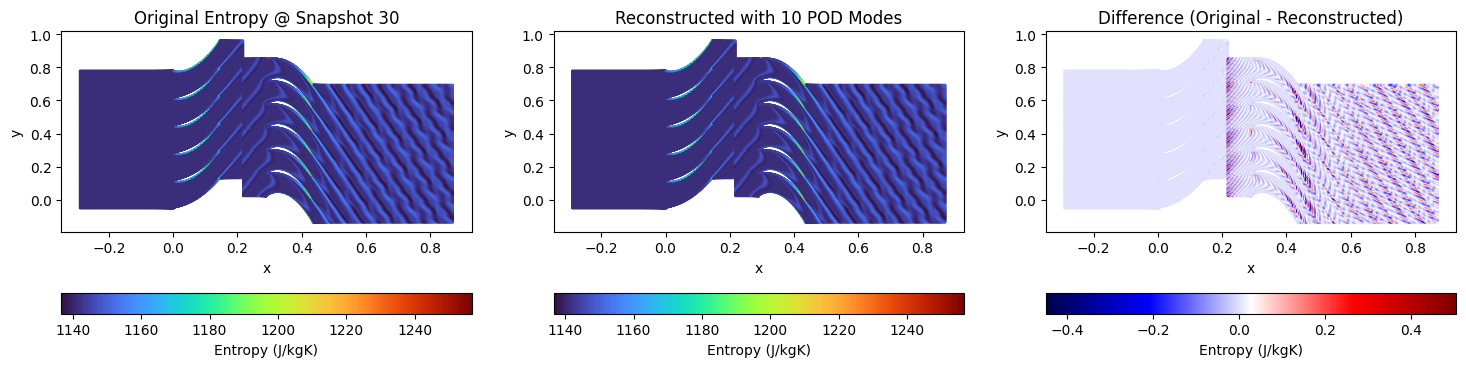

In [6]:
"""
------------------------ TASK 2.5 -----------------------------------------------
Visualised the quality of flow reconstruction by comparing the original flow field with its reconstruction using 10 POD modes. 
This highlights where and how much information is lost, and assesses how well the reduced-order model preserves key flow features.
Evaluated the effectiveness of the reduced-order model constructed using 10 POD modes
"""

i, r = [30, 10]          # [original snapshot, reconstructed mode] to compare

original_snapshot = X[:, i]                 # comparying original data at the same snapshot timestep
reconstructed_snapshot = X_r_full[:, i]     # comparying reconstucted data at the same snapshot timestep
difference_snapshot = original_snapshot - reconstructed_snapshot


plt.figure(figsize=(18, 4))

# Original
plt.subplot(1, 3, 1)
sc1 = plt.scatter(x, y, c=original_snapshot, cmap='turbo', s=0.3)
plt.title(f"Original Entropy @ Snapshot {i}")
plt.colorbar(sc1, orientation='horizontal', pad=0.2, label='Entropy (J/kgK)')
plt.xlabel('x'); plt.ylabel('y')

# Reconstructed
plt.subplot(1, 3, 2)
sc2 = plt.scatter(x, y, c=reconstructed_snapshot, cmap='turbo', s=0.3)
plt.title(f"Reconstructed with {r} POD Modes")
plt.colorbar(sc2, orientation='horizontal', pad=0.2, label='Entropy (J/kgK)')
plt.xlabel('x'); plt.ylabel('y')

# Difference
plt.subplot(1, 3, 3)
sc3 = plt.scatter(x, y, c=difference_snapshot, cmap='seismic', s=0.3)   # diverging colour map for better visual contrast
plt.title("Difference (Original - Reconstructed)")
plt.colorbar(sc3, orientation='horizontal', pad=0.2, label='Entropy (J/kgK)')
plt.xlabel('x'); plt.ylabel('y')
plt.show()